# Cross correlation with Quasar Catalog 

In [2]:
import sys
sys.path.append('../')
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
from cmass_modules import *
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [6]:
def catalog_masking(cat, nside_out = 128, area=None):
    print 'input cat ', cat.size
    cat = reddening_mask(cat = cat, nside_out = nside_out)
    print 'reddening ', cat.size
    if area is 'NGC' :
        cat = boss_mask(cat=cat, nside_out = nside_out, area=area)
    elif area is 'SGC' :
        cat = boss_mask(cat=cat, nside_out = nside_out, area=area)    
    elif area is 'SPT':
        cat = Cuts.keepGoodRegion(cat)
        cat = cat[cat['DEC']<-3.0]
        #cat = y1gold_mask(cat = cat, nside_out = nside_out)
    else : print 'area keyword input : either one of NGC SGC SPT'
        
    print 'output ', cat.size
    return cat

In [7]:
def making_healpix_density_map(cat = None, nside = 128, nest = False):
    hpind = np.arange(hp.nside2npix(nside))
    cat_ind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside= nside, nest= nest)
    N_gal, _ = np.histogram(cat_ind, bins = np.append(hpind, hpind.size) )
    unseen = (N_gal != 0.0)
    pixarea = hp.nside2pixarea(nside = nside)
    ra,dec = hpHEALPixelToRaDec(hpind, nside = nside)
    Map = np.zeros( (hpind.size, ), dtype = [('RA', 'float'),('DEC', 'float'),('PIXEL', 'float'), ('N_GAL', 'float') \
                                            , ('WEIGHT', 'float') , ('WEIGHT_RAND', 'bool') ])
    Map['RA'] = ra
    Map['DEC'] = dec
    Map['PIXEL'] = hpind
    Map['N_GAL'] = N_gal*1./pixarea    
    Map['WEIGHT'] = N_gal*1./pixarea 
    Map['WEIGHT_RAND'] = unseen
    return Map

In [8]:
def y1gold_mask(cat=None, nside_out = 4096):
    
    path = '/n/des/lee.5922/data/systematic_maps/'
    LSSGoldmask_hpind = fitsio.read(path+'Y1LSSmask_v2_redlimcut_il22_seeil4.0_4096ring.fits')['PIXEL']
    hpind_frac = np.zeros(hp.nside2npix(4096), dtype = 'float')
    hpind_frac[LSSGoldmask_hpind] = 1.0
    if nside_out == 4096 : hpind_frac_ud = hpind_frac
    else : hpind_frac_ud = hp.ud_grade(hpind_frac, pess=True, nside_out = nside_out)
    
    hpind_up = np.arange(hp.nside2npix(nside_out))
    
    cat = cat[cat['DEC']<-3.0]
    cat_hpind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside= nside_out, nest= False) 
    goodind = np.in1d(cat_hpind, hpind_up[[ hpind_frac_ud > 0.8]])
    return cat[goodind]  

In [9]:
def boss_mask(cat=None, area='SGC', nside_out = 1024):
    

    if area is 'SGC' : 
        boss_hpind = esutil.io.read('/n/des/lee.5922/data/cmass_cat/healpix_boss_footprint_SGC_1024.fits')
        
        #boss_hpind = hp.ud_grade(boss_hpind, pess=True, nside_out = nside)

    elif area is 'NGC':
        boss_hpind = esutil.io.read('/n/des/lee.5922/data/cmass_cat/healpix_boss_footprint_NGC_1024.fits')
        #boss_hpind = hp.ud_grade(boss_hpind, pess=True, nside_out = nside)
    else : 
        print 'area keyword input : SGC or NGC'
        return 0
     
    boss_hpfrac = np.zeros(hp.nside2npix(1024), dtype = 'float')
    boss_hpfrac[boss_hpind] = 1.0
    boss_hpind_up = np.arange(hp.nside2npix(nside_out))
    
    if nside_out == 1024 : boss_hpfrac_ud = boss_hpfrac
    else : boss_hpfrac_ud = hp.ud_grade(boss_hpfrac, pess=True, nside_out = nside_out)
    
    #print boss_hpfrac
    
    
    #boss_hpfrac_ud2 = boss_hpfrac_ud.copy()
    #boss_hpfrac_ud2[ boss_hpfrac_ud > 0.8] = 0
    #hp.mollview( boss_hpfrac_ud2, max = 1, nest = False)
    
    #if cat is None : 
    #    boss_hpmask = np.zeros(hp.nside2npix(4096), dtype = 'bool')
    #    boss_hpmask[boss_hpind] = 1
    #    return boss_hpmask
    
    #elif cat is not None : 
        
    hpind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside= nside_out, nest= False) 
    goodind = np.in1d(hpind, boss_hpind_up[[ boss_hpfrac_ud > 0.8]])
    return cat[goodind]

In [10]:
def moon_cont_mask(cat):
    
    mask = np.zeros(cat.size, dtype = 'bool') #(cat['MOON_LEV']=='0000')
    #combinations = []
    for i in [0,1,2]:
        for j in [0,1,2]:
            for k in [0,1,2]:
                for l in [0,1,2]:
                    filt = '{}{}{}{}'.format(i,j,k,l)
                    mask +=(cat['MOON_LEV']==filt)
    return mask
 

## Calling WISE AGN

In [180]:
agn = fitsio.read('/n/des/lee.5922/data/wise_cat/wiseallagn.fits')

In [13]:
wise = esutil.io.read('/n/des/lee.5922/data/wise_cat/wise_allsky.allsky_4band_p3as_psd25158.fits',  upper=True)
HealInds = hpRaDecToHEALPixel(wise['RA'], wise['DEC'], nside=  512, nest= False)

wise = rf.append_fields(wise,'HEALIndex',HealInds,dtypes=HealInds.dtype)
cont_mask = moon_cont_mask(wise)
moonrevHPind = wise['HEALIndex'][cont_mask]
wise = None
#wise = wise[cont_mask]
#wise = wise[(wise['CC_FLAGS'] != '0000')]

In [137]:
def wise_mask(cat=None):
    wise_hpind = fitsio.read('/n/des/lee.5922/data/wise_cat/mask_wise_agn_nside128.fits')
    cat_hpind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside= 128, nest= False) 
    goodind = np.in1d(cat_hpind, wise_hpind )
    return cat[goodind]      

In [178]:
def moonrev_mask(moonrevHPind, cat):
    catHPind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside=  512, nest= False)
    hpmask = np.in1d( catHPind, moonrevHPind )   
    return cat #[hpmask]

In [181]:
agn = moonrev_mask(moonrevHPind, agn)
agn = wise_mask(cat = agn)

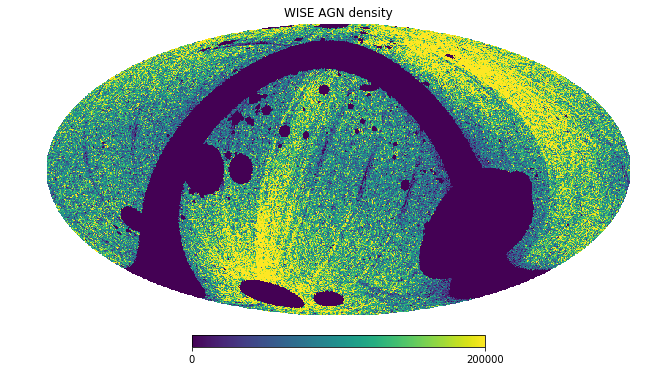

In [182]:
agn_galmap= making_healpix_density_map(cat = agn, nside = 128, nest = False)
hp.mollview(agn_galmap['WEIGHT'], nest=False, title="WISE AGN density", max = 2e05)

### Cross correlation with CMASS SGC

In [183]:
#CMASS SGC
path = '/n/des/lee.5922/data/cmass_cat/'
#cmass_sgc = esutil.io.read(path+'galaxy_DR12v5_CMASS_South.fits.gz')
cmass_ngc = esutil.io.read(path+'galaxy_DR12v5_CMASS_North.fits.gz')
#random_sgc = esutil.io.read(path+'random0_DR12v5_CMASS_South.fits.gz')
random_ngc = esutil.io.read(path+'random0_DR12v5_CMASS_North.fits.gz')

cmass = cmass_ngc
random = random_ngc

w_sgc = cmass['WEIGHT_FKP'] * cmass['WEIGHT_SYSTOT']*( cmass['WEIGHT_CP'] + cmass['WEIGHT_NOZ'] - 1. )
w_rand = random['WEIGHT_FKP']
cmass = rf.append_fields(cmass,'WEIGHT', w_sgc, dtypes=w_sgc.dtype)
random = rf.append_fields(random,'WEIGHT_RAND', w_rand, dtypes=w_rand.dtype)

cmass = boss_mask(cat=cmass, area='NGC')
random = boss_mask(cat=random, area='NGC')

cmass = moonrev_mask(moonrevHPind, cmass)
random = moonrev_mask(moonrevHPind, random)

In [184]:
agn_boss = boss_mask(cat=agn, area='NGC')
random_agn_boss = boss_mask(cat = uniform_random_on_sphere(agn_boss, size = agn_boss.size * 30 ), area = 'NGC')
random_agn_boss = moonrev_mask(moonrevHPind, random_agn_boss)
random_agn_boss = wise_mask(cat = random_agn_boss)
agn_spt = y1gold_mask(cat=agn)
random_agn_spt = y1gold_mask(cat = uniform_random_on_sphere(agn_spt, size = agn_boss.size * 30 ))
random_agn_spt = moonrev_mask(moonrevHPind, random_agn_spt)
random_agn_spt = wise_mask(cat = random_agn_spt)

agn_sgc = boss_mask(cat=agn, area='SGC')
random_agn_sgc = boss_mask(cat = uniform_random_on_sphere(agn_sgc, size = agn_boss.size * 30 ), area = 'SGC')
random_agn_sgc = moonrev_mask(moonrevHPind, random_agn_sgc)
random_agn_sgc = wise_mask(cat = random_agn_sgc)

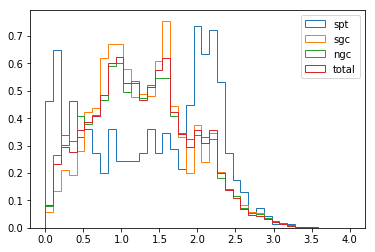

In [185]:
zbins = np.linspace(0.001, 4, 40)

fig, ax = plt.subplots()
_ = ax.hist( agn_spt['REDSHIFT'], bins = zbins, normed = True, histtype='step', label='spt')
_ = ax.hist( agn_sgc['REDSHIFT'], bins = zbins, normed = True, histtype='step', label='sgc')
_ = ax.hist( agn_boss['REDSHIFT'], bins = zbins, normed = True, histtype='step', label='ngc')
_ = ax.hist( agn['REDSHIFT'], bins = zbins, normed = True, histtype='step', label='total')

ax.legend()

In [121]:
np.sum(agn_spt['REDSHIFT'] == 0 )

68055

In [122]:
agn_spt.size

68732

In [77]:
agn_spt[ agn_spt['REDSHIFT'] > 0.001 ].size

677

In [161]:
Nz1_all = np.sum( (agn['REDSHIFT'] < 0.8) & (agn['REDSHIFT'] > 0.4)) 
Nz2_all = agn[ agn['REDSHIFT'] > 0.001 ].size

Nz1 = np.sum( (agn_boss['REDSHIFT'] < 0.8) & (agn_boss['REDSHIFT'] > 0.4)) 
Nz2 = agn_boss[ agn_boss['REDSHIFT'] > 0.001 ].size

Nz1_sgc = np.sum( (agn_sgc['REDSHIFT'] < 0.8) & (agn_sgc['REDSHIFT'] > 0.4))
Nz2_sgc = agn_sgc[ agn_sgc['REDSHIFT'] > 0.001 ].size

Nz1_spt = np.sum( (agn_spt['REDSHIFT'] < 0.8) & (agn_spt['REDSHIFT'] > 0.4)) 
Nz2_spt = agn_spt[ agn_spt['REDSHIFT'] > 0.001 ].size

print ''
print 'name  z(0.4~0.75)  z_valid     total   fraction   expected size'
print '-----------------------------------------------------------------------'
print 'all    {:8d}   {:8d}  {:8d}     {:0.3f}    {:8.0f}'.format( Nz1_all, Nz2_all, agn.size, Nz1_all * 1./Nz2_all, agn.size *Nz1_all * 1./Nz2_all  )
print 'ngc    {:8d}   {:8d}  {:8d}     {:0.3f}    {:8.0f}'.format( Nz1,Nz2, agn_boss.size, Nz1 * 1./Nz2, agn_boss.size *Nz1 * 1./Nz2 )
print 'sgc    {:8d}   {:8d}  {:8d}     {:0.3f}    {:8.0f}'.format(  Nz1_sgc, Nz2_sgc, agn_sgc.size, Nz1_sgc * 1./Nz2_sgc, agn_sgc.size *Nz1_sgc * 1./Nz2_sgc )
print 'spt    {:8d}   {:8d}  {:8d}     {:0.3f}    {:8.0f}'.format(  Nz1_spt, Nz2_spt, agn_spt.size, Nz1_spt * 1./Nz2_spt, agn_spt.size *Nz1_spt * 1./Nz2_spt)
print ''



name  z(0.4~0.75)  z_valid     total   fraction   expected size
-----------------------------------------------------------------------
all       17797     117576    727311     0.151      110090
ngc       12348      77064    196608     0.160       31503
sgc        2547      16782     52228     0.152        7927
spt          57        512     45973     0.111        5118



In [186]:
dmass_spt = esutil.io.read('../output/n2_2/dmass_spt.fits')
dmass_random = Cuts.keepGoodRegion(uniform_random_on_sphere(dmass_spt, size = dmass_spt.size * 10 ))
dmass_random = dmass_random[dmass_random['DEC']< -3.0]

dmass_spt = moonrev_mask(moonrevHPind, dmass_spt)
dmass_random = moonrev_mask(moonrevHPind, dmass_random)

In [202]:


"""

w_twomass = np.ones(twomass_in_cmass.size)
w_twomass_rand = np.ones(twomass_random_in_cmass.size)
twomass_in_cmass = rf.append_fields(twomass_in_cmass,'WEIGHT', w_twomass)
twomass_random_in_cmass = rf.append_fields(twomass_random_in_cmass,'WEIGHT_RAND', w_twomass_rand)

w_dmass = np.ones(dmass_in_twomass.size)
w_dmass_rand = np.ones(dmass_randoms_in_twomass.size)
dmass_in_twomass = rf.append_fields(dmass_in_twomass,'WEIGHT', w_dmass)
dmass_randoms_in_twomass = rf.append_fields(dmass_randoms_in_twomass,'WEIGHT_RAND', w_dmass_rand)

w_dmass = np.ones(twomass_in_spt.size)
w_dmass_rand = np.ones(twomass_random_in_spt.size)
twomass_in_spt = rf.append_fields(twomass_in_spt,'WEIGHT', w_dmass)
twomass_random_in_spt = rf.append_fields(twomass_random_in_spt,'WEIGHT_RAND', w_dmass_rand)
"""
#
#

"\n\nw_twomass = np.ones(twomass_in_cmass.size)\nw_twomass_rand = np.ones(twomass_random_in_cmass.size)\ntwomass_in_cmass = rf.append_fields(twomass_in_cmass,'WEIGHT', w_twomass)\ntwomass_random_in_cmass = rf.append_fields(twomass_random_in_cmass,'WEIGHT_RAND', w_twomass_rand)\n\nw_dmass = np.ones(dmass_in_twomass.size)\nw_dmass_rand = np.ones(dmass_randoms_in_twomass.size)\ndmass_in_twomass = rf.append_fields(dmass_in_twomass,'WEIGHT', w_dmass)\ndmass_randoms_in_twomass = rf.append_fields(dmass_randoms_in_twomass,'WEIGHT_RAND', w_dmass_rand)\n\nw_dmass = np.ones(twomass_in_spt.size)\nw_dmass_rand = np.ones(twomass_random_in_spt.size)\ntwomass_in_spt = rf.append_fields(twomass_in_spt,'WEIGHT', w_dmass)\ntwomass_random_in_spt = rf.append_fields(twomass_random_in_spt,'WEIGHT_RAND', w_dmass_rand)\n"

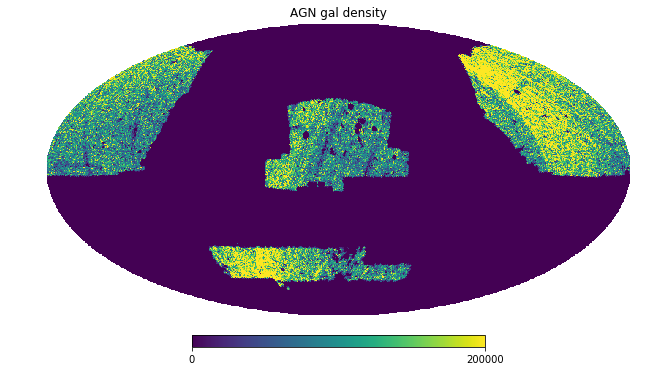

In [187]:
#dmass_galmap= making_healpix_density_map(cat = dmass_spt, nside = 128, nest = False)
#cmass_galmap= making_healpix_density_map(cat = cmass, nside = 128, nest = False)
#hp.mollview(cmass_galmap['WEIGHT'] + dmass_galmap['WEIGHT'], nest=False, title="CMASS NGC gal density", max = 5e05)

agn_boss_galmap = making_healpix_density_map(cat = agn_boss, nside = 128, nest = False)
agn_sgc_galmap = making_healpix_density_map(cat = agn_sgc, nside = 128, nest = False)
agn_spt_galmap = making_healpix_density_map(cat = agn_spt, nside = 128, nest = False)

hp.mollview(agn_boss_galmap['WEIGHT'] +agn_sgc_galmap['WEIGHT'] + agn_spt_galmap['WEIGHT'], nest=False, title="AGN gal density", max = 2e05)


#### Cross Correlation Function

In [156]:
from systematics_module.corr import angular_correlation, cross_angular_correlation

In [22]:
#cmass_ind = np.random.choice(np.arange(cmass_in_twomass.size), size = cmass_in_twomass.size/10)

#twomass_ind = np.random.choice(np.arange(twomass_in_cmass.size), size = twomass_in_cmass.size/10)
#twomass_random_ind = np.random.choice(np.arange(twomass_random_in_cmass.size), size = twomass_in_cmass.size)


cross_angular_correlation(data = dmass_spt, 
                          data2 = agn_spt, 
                          rand = dmass_random, 
                          rand2= dmass_random, 
                          njack = 100,  
                          dir = '../data_txt/',
                          weight = [None, None, None, None], suffix = '_agn_x_dmass_jk100')

X (1000, 2)  centers (100, 2)  tol=1e-05  maxiter=200
16 iterations  cluster sizes: [11  7 14 11 11 15  6  6 10  9  4 12  7  9  9  6  9  8  3  8 21 11 11  4
 17  4 12  6  9 27  8 12  6 10  9 14 10 10  9  4 24  8  7 14  5  9  8 16
  8  8 23  8  5  8  6  4  5 16  8  8  7 13 24 10  8  7 12 16 11 15 12 10
  7  8  3 13 17 13 10  8  8 13  9 13  7  9 15  9 13  8 13  7 13  5  9  9
  2 11 10  6]
X (112398, 2)  centers (100, 2)  tol=1e-05  maxiter=200
58 iterations  cluster sizes: [1198 1047 1283  829  943 1256  975  678  952 1085 1019 1714  770 1115
 1138  828 1127 1294 1081  709 1583 1252 1258 1010 1219 1110 1013  848
  994 1776 1157 1010 1014 1056 1185 1561  887 1226 1110  963 1199 1091
 1036 1153 1241 1133  719 1188  673 1112 1199 1770 1303  900 1119 1146
 1166 1049  734 1136 1413  957 1592 1421 1352  762  794 1352 1105 1446
  965 1171 1605 1026 1148 1246 1154 1362 1140 1200  752 1567 1258 1597
  619  957 1243  982 1135 1011 1614  915 1046 1409 1025  993  485 1027
 1299  913]
. . . . . . . .

In [30]:
random_ind = np.random.choice(np.arange(random.size), size = cmass.size*10)
cmass_ind = np.random.choice(np.arange(cmass.size), size = cmass.size/10)

cross_angular_correlation(data = cmass[cmass_ind], 
                          data2 = agn_boss, 
                          rand = random[random_ind], 
                          rand2= random_agn_boss, 
                          njack = 200,  
                          dir = '../data_txt/',
                          weight = [None, None, None, None], suffix = '_agn_x_cmass_ngc_jk200' )

X (2000, 2)  centers (200, 2)  tol=1e-05  maxiter=200
18 iterations  cluster sizes: [ 3 10  9  7  5  8  7  6 10  4 10  6  9 10 19 15  5  9  7  8  7  5  6 10
 10  6  7 16 18  7 11 18 15  8 14 13 11  5 11  9 10 16 16  8  8  5 15  8
  9 15 11 13 16 15  9 13 14 14 13 13  9 14  7 12 11  8  6  8  8 12 13 18
  8  7  5 15  7  9  9  8  9  8 13 15 11  7  8  9 12 11 11  9 13 12 10 13
  2  9  8 11 22 11 16  6  7 12 16 10 14  5 16 15 13  9 11  8  1 12  6 11
  4  9  3  4  3 14  5 10  7  9  6  8 11  6  7  9  3 10 12  5 13 11 12 13
 12  7  7 13 10  5 13 13  9  9  6 11  8 12 17 10  3  5  3 12 17  4  5  5
  5 23 12  4 18  9  8  9 11 17  8 10  8 12  7  8 13  7 12  9 20 14 13 10
 14  9 15  8 12  7 16 11]
X (61870, 2)  centers (200, 2)  tol=1e-05  maxiter=200
69 iterations  cluster sizes: [288 249 337 251 318 209 252 285 350 223 327 308 338 242 408 321 300 352
 214 334 328 322 272 319 290 328 252 299 428 288 293 287 383 333 378 341
 368 241 338 318 345 336 301 278 303 300 317 295 289 389 283 291 421 300
 2

In [188]:
from systematics_module.corr import _cross_acf
meanr, xi, xi_err = _cross_acf(dmass_spt, agn_spt, dmass_random, random_agn_spt, nbins=30, min_sep=0.005, max_sep=250/60.)
meanr3, xi3, xi_err3 = _cross_acf(cmass, agn_boss, random, random_agn_boss,nbins=30, min_sep=0.005, max_sep=250/60.)
#meanr3, xi3, xi_err3 = _cross_acf(dmass_spt, agn_spt, dmass_random, random_agn_spt)



. .


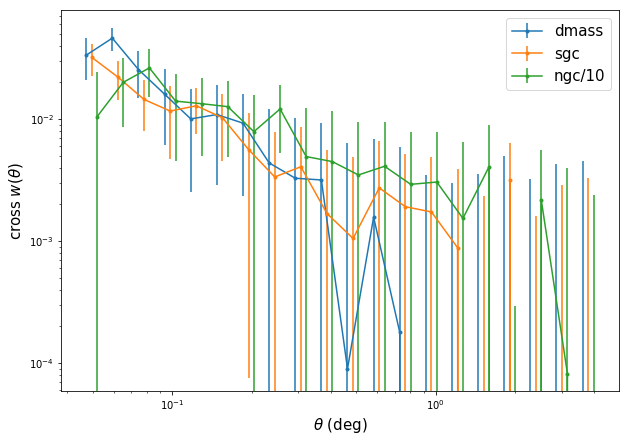

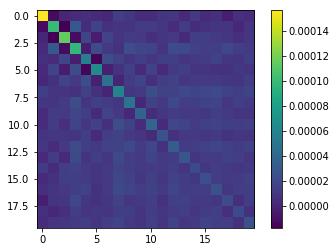

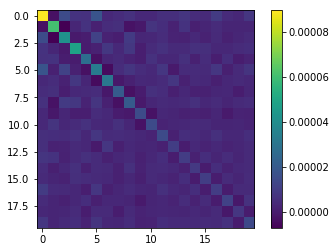

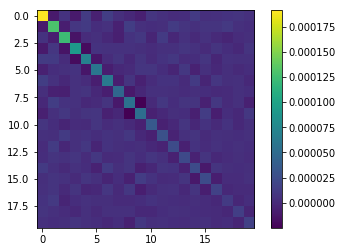

In [4]:

#dat1 = '../data_txt/acf_cross_agn_x_cmass_sgc_jk100'
#dat1 = '../data_txt/acf_cross_agn_x_cmass_ngc_jk200'
#dat1 = '../data_txt/acf_cross_agn_x_dmass_jk80'


#dat1 = '../data_txt/acf_auto_agn_ngc_jk200'

dat1 = '../data_txt/acf_cross_agn_x_dmass_jk100'
dat2 = '../data_txt/acf_cross_agn_x_cmass_sgc_jk100'
dat3 = '../data_txt/acf_cross_agn_x_cmass_ngc_jk200'
#dat2 = '../data_txt/acf_cross_agn_x_cmass_sgc_no1'
#dat2 = '../data_txt/acf_cross_agn_x_dmass_no1'


fig, ax = plt.subplots(figsize = (10,7))

meanr, xi, xi_err = np.loadtxt(dat1+'.txt', unpack=True)
meanr2, xi2, xi_err2 = np.loadtxt(dat2+'.txt',unpack=True)
meanr3, xi3, xi_err3 = np.loadtxt(dat3+'.txt',unpack=True)

cov = np.loadtxt(dat1+'.cov')
cov2 =  np.loadtxt(dat2+'.cov')
cov3 =  np.loadtxt(dat3+'.cov')
invcov = np.linalg.inv(cov)
invcov2 = np.linalg.inv(cov2)
invcov3 = np.linalg.inv(cov3)

ax.axhline(y=0, color='grey', linestyle='--')

ax.errorbar(meanr, xi, yerr = xi_err, fmt = '.-', label='dmass')
ax.errorbar(meanr2*1.05, xi2, yerr = xi_err2, fmt = '.-', label='sgc')
ax.errorbar(meanr3*1.1, xi3, yerr = xi_err3, fmt = '.-', label='ngc/10')

#ax.set_ylim(-0.05, 0.08)
#ax.set_xlim(2.5, 250)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 15)
ax.set_ylabel(r'cross $w(\theta)$', fontsize = 15)
ax.legend(loc='best', fontsize = 15)

fig.subplots_adjust(wspace=0.2, hspace=0)


fig, ax = plt.subplots()
im = ax.imshow(cov)
fig.colorbar(im, ax=ax)

fig, ax = plt.subplots()
im = ax.imshow(cov2)
fig.colorbar(im, ax=ax)

fig, ax = plt.subplots()
im = ax.imshow(cov3)
fig.colorbar(im, ax=ax)

In [170]:
angular_correlation(data = agn_boss, 
                    rand = random_agn_boss, 
                    njack = 100,  
                    dir = '../data_txt/',
                    weight = [None, None], suffix = '_agn_ngc_jk100' )

angular_correlation(data = agn_sgc, 
                    rand = random_agn_sgc, 
                    njack = 100,  
                    dir = '../data_txt/',
                    weight = [None, None], suffix = '_agn_sgc_jk100' )

angular_correlation(data = agn_spt, 
                    rand = random_agn_spt, 
                    njack = 100,  
                    dir = '../data_txt/',
                    weight = [None, None], suffix = '_agn_spt_jk100' )

calculate angular correlation function
X (1000, 2)  centers (100, 2)  tol=1e-05  maxiter=200
14 iterations  cluster sizes: [10 16 16  3 19 15 14  5  5  7  8 16 18 17  8  9  7 12  4 15  8  9 12 11
  9 11  6 15  5 13  9  8  6 10 11  9 15  9  6  9 15 13 14 13 13 15 10  7
  9  6  9  8 10 13  9  8  7 10  7  8  5 17  8  9 11  8  8 12 16 19 14  7
  5 19 12 10  6  6  4 11 10  8  2 12  9  8  5  9 12  9 19 10  6 13  6  6
  9  9  7  5]
X (196608, 2)  centers (100, 2)  tol=1e-05  maxiter=200
61 iterations  cluster sizes: [2288 1683 2300 1290 2719 2122 1985 2366 1370 1800 2038 1874 2031 1949
 1564 1571 1773 1545 1419 1974 2308 2244 2178 2272 1467 2186 2168 2477
 1567 2254 2174 2147 2038 2200 1519 1880 2443 2503 1756 1826 1551 2473
 1738 2471 1960 2060 1418 1891 1402 1676 1864 1759 1825 2093 1670 1864
 1751 1538 2212 1774 2086 1951 2113 2235 1717 1899 1835 1753 1906 2189
 2165 2072 2368 2401 2192 2479 2063 1356 1849 1814 1945 2035 1928 2465
 1705 1842 2004 2408 2337 1540 2139 1802 1671 2281 1621 182

In [ ]:
from systematics_module.corr import _corrfunc_acf_auto, _acf
#theta, wtheta_agn_spt = _corrfunc_acf_auto(agn_spt, random_agn_spt)
#theta, wtheta_agn_ngc = _corrfunc_acf_auto(agn_boss, random_agn_boss)
meanr, xi, xi_err = _acf(agn_spt, random_agn_spt, nbins=30, min_sep=0.005, max_sep=1.0)
meanr2, xi2, xi_err2 = _acf(agn_sgc, random_agn_sgc,nbins=30, min_sep=0.005, max_sep=1.0)
meanr3, xi3, xi_err3 = _acf(agn_boss, random_agn_boss,nbins=30, min_sep=0.005, max_sep=1.0)


In [153]:
agn_sgc.size, random_agn_sgc.size

(52228, 507360)

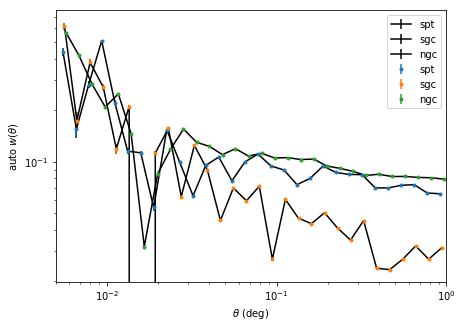

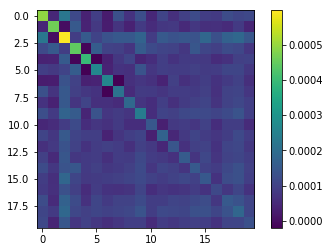

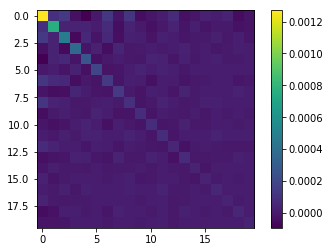

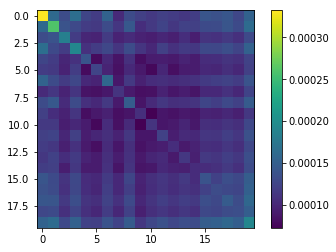

In [177]:

#dat1 = '../data_txt/acf_cross_agn_x_cmass_sgc_jk100'
#dat1 = '../data_txt/acf_cross_agn_x_cmass_ngc_jk200'
#dat1 = '../data_txt/acf_cross_agn_x_dmass_jk80'


#dat1 = '../data_txt/acf_auto_agn_ngc_jk200'

dat1 = '../data_txt/acf_auto_agn_spt_jk100'
dat2 = '../data_txt/acf_auto_agn_sgc_jk100'
dat3 = '../data_txt/acf_auto_agn_ngc_jk100'


#dat2 = '../data_txt/acf_cross_agn_x_cmass_sgc_no1'
#dat2 = '../data_txt/acf_cross_agn_x_dmass_no1'


fig, ax = plt.subplots(figsize = (7,5))

ax.errorbar(meanr, xi, yerr = xi_err, fmt = 'k-', label='spt')
ax.errorbar(meanr2*1.02, xi2, yerr = xi_err2, fmt = 'k-', label='sgc')
ax.errorbar(meanr3*1.05, xi3, yerr = xi_err3, fmt = 'k-', label='ngc')


#meanr, xi, xi_err = np.loadtxt(dat1+'.txt', unpack=True)
#meanr2, xi2, xi_err2 = np.loadtxt(dat2+'.txt',unpack=True)
#meanr3, xi3, xi_err3 = np.loadtxt(dat3+'.txt',unpack=True)

cov = np.loadtxt(dat1+'.cov')
cov2 =  np.loadtxt(dat2+'.cov')
cov3 =  np.loadtxt(dat3+'.cov')
invcov = np.linalg.inv(cov)
invcov2 = np.linalg.inv(cov2)
invcov3 = np.linalg.inv(cov3)

ax.axhline(y=0, color='grey', linestyle='--')

ax.errorbar(meanr, xi, yerr = xi_err, fmt = '.', label='spt')
ax.errorbar(meanr2*1.02, xi2, yerr = xi_err2, fmt = '.', label='sgc')
ax.errorbar(meanr3*1.05, xi3, yerr = xi_err3, fmt = '.', label='ngc')

#ax.set_ylim(0.01, 0.2)
ax.set_xlim(0.005, 1.0)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\theta$ (deg)')
ax.set_ylabel(r'auto $w(\theta)$')
ax.legend(loc='best')

fig.subplots_adjust(wspace=0.2, hspace=0)





fig, ax = plt.subplots()
im = ax.imshow(cov)
fig.colorbar(im, ax=ax)

fig, ax = plt.subplots()
im = ax.imshow(cov2)
fig.colorbar(im, ax=ax)

fig, ax = plt.subplots()
im = ax.imshow(cov3)
fig.colorbar(im, ax=ax)